In [22]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import sys
from pathlib import Path 
sys.path.append(str(Path.cwd().parent / "src"))

from config import *

In [ ]:
# Chargement des donnees brutes
df = pd.read_csv(RAW_DATA_FILE)

# Afficher les premieres lignes des donnees
print(df.head())
print(df.columns)

df['Total ESG Risk score'] = pd.to_numeric(df['Total ESG Risk score'], errors='coerce')
df['Controversy Score'] = pd.to_numeric(df['Controversy Score'], errors='coerce')
df.columns = df.columns.str.strip()
df.rename(columns={'Total ESG Risk score': 'Total ESG Risk Score'}, inplace=True)


  Symbol                      Name  \
0   ENPH      Enphase Energy, Inc.   
1    EMN  Eastman Chemical Company   
2    DPZ       Domino's Pizza Inc.   
3    DAY            Dayforce, Inc.   
4    DVA               Davita Inc.   

                                             Address             Sector  \
0  47281 Bayside Parkway\r\nFremont, CA 94538\r\n...         Technology   
1  200 South Wilcox Drive\r\nKingsport, TN 37662\...    Basic Materials   
2  30 Frank Lloyd Wright Drive\r\nAnn Arbor, MI 4...  Consumer Cyclical   
3  3311 East Old Shakopee Road\r\nMinneapolis, MN...         Technology   
4  2000 16th Street\r\nDenver, CO 80202\r\nUnited...         Healthcare   

                  Industry Full Time Employees  \
0                    Solar               3,157   
1      Specialty Chemicals              14,000   
2              Restaurants               6,500   
3   Software - Application               9,084   
4  Medical Care Facilities              70,000   

                   

In [56]:
# Nettoyage des donnees
### a) Suppression des colonnees inutiles
columns_to_drop = ['Symbol', 'Name', 'Address', 'Sector', 'Industry', 'Full Time Employees', 'Description', 'Controversy Level', 'ESG Risk Percentile', 'ESG Risk Level'] # Exemple de colonnes a supprimer
df.drop(columns=columns_to_drop, axis=1, inplace=True)


### b) Verification des valeurs manquantes
print("\nValeurs manquantes dans les colonnes :")
print(df.isnull().sum())

### c) Gestion des valeurs manquantes
# Remplir les valeurs manquantes avec la moyenne pour les colonnes numeriques
df.fillna(df.mean(), inplace=True)

# Verification apres traitement
print("\nValeurs manquantes apres traitement:")
print(df.isnull().sum())




Valeurs manquantes dans les colonnes :
Total ESG Risk Score       73
Environment Risk Score     73
Governance Risk Score      73
Social Risk Score          73
Controversy Score         100
dtype: int64

Valeurs manquantes apres traitement:
Total ESG Risk Score      0
Environment Risk Score    0
Governance Risk Score     0
Social Risk Score         0
Controversy Score         0
dtype: int64


In [58]:

# 2. Traitement des Outliers
## a) Detection des outliers avec la methode de l'ecart interquatile (IQR)
Q1 = df[NUMERIC_COLUMNS].quantile(0.25)
Q3 = df[NUMERIC_COLUMNS].quantile(0.75)
IQR = Q3 - Q1

# Identifier les outliers
outliers = ((df[NUMERIC_COLUMNS] < (Q1 - 1.5 * IQR)) | (df[NUMERIC_COLUMNS] > (Q3 + 1.5 * IQR)))

# Affichage des valeurs detectees comme outliers
print("\nOutliers detectes (True = Outlier):")
print(outliers)

### b) Traitement des outliers
# Remplacer les outliers par la mediane de chaque colonne
df_no_outliers = df.copy()
df_no_outliers[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].mask(outliers, df[NUMERIC_COLUMNS].median(), axis=0)

# Affichage des valeurs apres traitement des outliers
print("\nDonnees apres traitement des outliers:")
print(df_no_outliers.describe())



Outliers detectes (True = Outlier):
     Total ESG Risk Score  Environment Risk Score  Governance Risk Score  \
0                   False                   False                  False   
1                   False                   False                  False   
2                   False                   False                  False   
3                   False                   False                  False   
4                   False                   False                  False   
..                    ...                     ...                    ...   
498                 False                   False                  False   
499                 False                   False                  False   
500                 False                   False                  False   
501                 False                   False                  False   
502                 False                    True                  False   

     Social Risk Score  Controversy Score  
0     


Donnees apres normalisation:
   Total ESG Risk Score  Environment Risk Score  Governance Risk Score  \
0              0.042819                0.106059               0.267440   
1              0.668397                1.847767               0.181767   
2              1.316186                1.305043              -0.023656   
3              0.042819                0.106059               0.267440   
4              0.219928               -1.285230               1.414304   

   Social Risk Score  Controversy Score  
0           0.055272           1.410674  
1          -1.045695          -0.708881  
2           1.108798          -0.708881  
3           0.055272           1.410674  
4           1.748413          -0.708881  


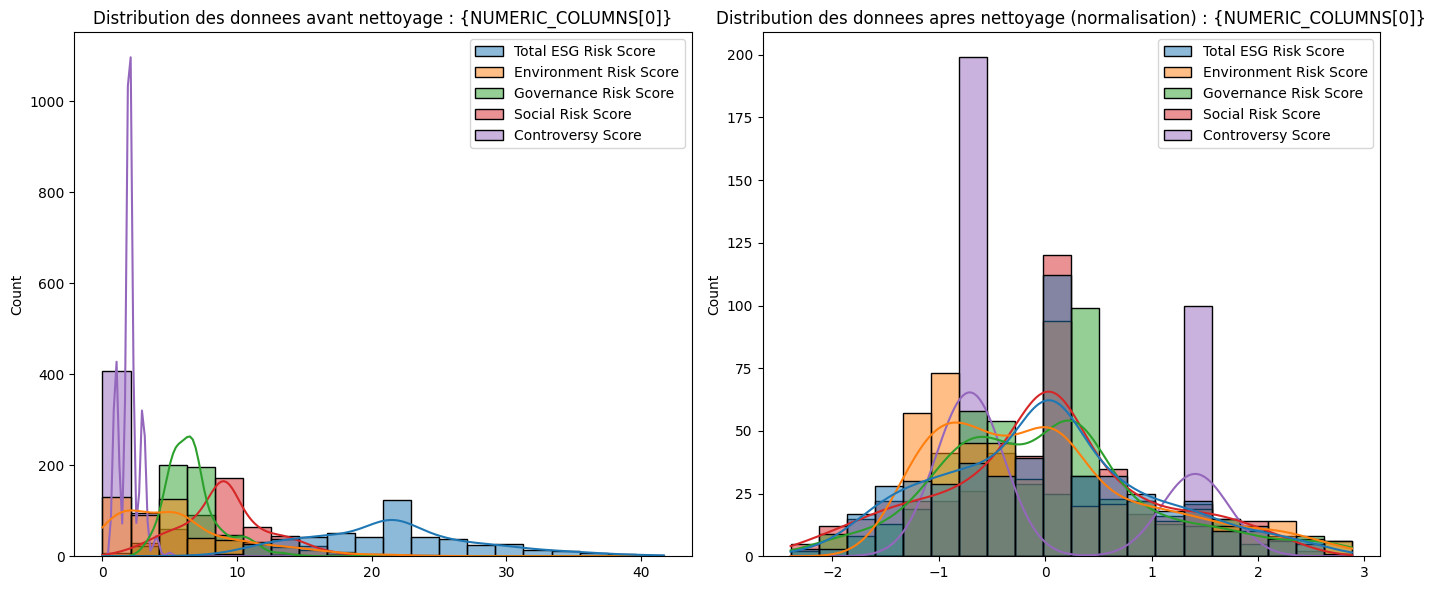


Donnees nettoyees et sauvegardees dans C:\Users\HP\OneDrive\Documenten\1-Projects\Professionnel\Projets pro\Modele_scoring_ESG\data\cleaned\cleaned_esg_data.csv


In [59]:
# 3. Normalisation des donnees numeriques
scaler = StandardScaler()

# Normalisation des donnees numeriques
df_normalized = df_no_outliers.copy()
df_normalized[NUMERIC_COLUMNS] = scaler.fit_transform(df_no_outliers[NUMERIC_COLUMNS])

# Afficher les premieres lignes apres normalisation
print("\nDonnees apres normalisation:")
print(df_normalized.head())

# 4. Visualisation des donnees apres traitement
## a) Histogrammes pour visualiser la distribution des donnees avant et apres nettoyage
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogramme des donnees avant nettoyage
sns.histplot(df[NUMERIC_COLUMNS], bins=20, kde=True, color="blue", ax=axes[0])
axes[0].set_title("Distribution des donnees avant nettoyage : {NUMERIC_COLUMNS[0]}")

# Histogramme des donnees apres nettoyage (normalisation)
sns.histplot(df_normalized[NUMERIC_COLUMNS], bins=20, kde=True, color="green", ax=axes[1])
axes[1].set_title("Distribution des donnees apres nettoyage (normalisation) : {NUMERIC_COLUMNS[0]}")

plt.tight_layout()
plt.show()

# Sauvegarde des donnees nettoyees
# Utilisation du chemin defini dans config.py pour sauvegarder les donnees nettoyees
df_normalized.to_csv(CLEANED_DATA_FILE, index=False)
print(f"\nDonnees nettoyees et sauvegardees dans {CLEANED_DATA_FILE}")